In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import accelerate # without importing transformers and accelerate below packages load with depreciated version
import transformers 
from transformers import AutoTokenizer, AutoModel, DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from joblib import dump, load

import os
from copy import copy
import warnings
warnings.filterwarnings("ignore")

transformers.__version__, accelerate.__version__



('4.35.2', '0.25.0')

## Data loading

In [2]:
#loading main dataframe
main_df = pd.read_csv("preprocessed_datasets/main_df.csv")

#adding clustering results
clustering_lda = pd.read_csv("preprocessed_datasets/ldatfidf4_nouns.csv")
clustering_lda.columns = ["id","clustering_lda"]
clustering_gss = pd.read_csv("preprocessed_datasets/gssdmm7_nouns.csv")
clustering_gss.columns = ["id","clustering_gss"]
main_df = main_df.join(clustering_lda.set_index("id"), on="id")
main_df = main_df.join(clustering_gss.set_index("id"), on="id")

#data inspection
main_df.head()

,Unnamed: 0,id,type,domain,scraped_at,url,authors,title,content,word_count,char_count,word_density,polarity,subjectivity,nouns,noun_chunks,entities,lemmas,clustering_lda,clustering_gss
0,0,7025856,political,dailykos.com,2017-11-27,https://www.dailykos.com/stories/2013/10/17/12...,"Backgroundurl Avatar_Large, Nickname, Joined, ...",Classic Bachmann: Default avoided because Repu...,"Pssst, Michele, you just called yourself not a...",212,982,0.215666,0.154630,0.662191,"['adult', 'Pssst', 'adult', 'dice', 'adults', ...","['Michele', 'Republicans', 'default', 'intense...","['Pssst, Michele', 'Michele', 'Republicans', ""...","['Pssst', 'Michele', 'call', 'adult', 'pssst',...",0,4
1,1,1966549,political,breitbart.com,2017-11-10,http://www.breitbart.com/jerusalem/2016/06/01/...,"Aaron Klein, Ali Waked","EXCLUSIVE: Hamas, Hezbollah Recruiting Fatah M...",TEL AVIV – The Israel Defense Forces on Monday...,367,1972,0.186011,0.046875,0.414167,"['city', 'refugee', 'camps', 'suspicion', 'pos...","['TEL AVIV', 'Monday', ' Palestinians', 'Nablu...","['TEL AVIV', 'The Israel Defense Forces', 'Pal...","['TEL', 'AVIV', 'Israel', 'Defense', 'Forces',...",2,0
2,2,2628942,political,alternet.org,2017-11-13,https://www.alternet.org/environment/revealed-...,NaN,Revealed: FBI Terrorism Taskforce Investigatin...,Revealed: FBI Terrorism Taskforce Investigatin...,904,4889,0.184867,-0.039660,0.413462,"['leaders', 'movement', 'fear', 'terrorists', ...","['FBI Terrorism Taskforce', 'Standing Rock Act...","['FBI Terrorism Taskforce Investigating', 'Peg...","['reveal', 'FBI', 'Terrorism', 'Taskforce', 'i...",0,6
3,3,3382763,political,dailykos.com,2017-11-18,https://www.dailykos.com/stories/2006/9/11/245...,"Backgroundurl Avatar_Large, Nickname, Joined, ...",What's Condi Doing Today?,The Halifax Peace Coalition questioned the mot...,242,1221,0.198036,0.205208,0.407813,"['motivation', 'visit', 'relations', 'campaign...","['support', 'Afghanistan', 'Canadian troops', ...","['The Halifax Peace Coalition', 'Rice', 'Afgha...","['Halifax', 'Peace', 'Coalition', 'question', ...",3,0
4,4,2034907,political,nationalreview.com,2017-11-10,http://www.nationalreview.com/corner/81541,Michael Ledeen,National Review,"Well, it’s very important, actually, because i...",337,1640,0.205363,0.127504,0.521075,"['hands', 'yellowcake', 'asset', 'president', ...","['Saddam', 'yellowcake', 'Niger', 'Seymour Her...","['Brits', 'Saddam', 'Niger', 'CIA', 'Seymour H...","['important', 'actually', 'explain', 'Brits', ...",2,0


In [3]:
X = main_df.content
y = main_df['type'].astype('category').cat.codes
X.iloc[0]

'Pssst, Michele, you just called yourself not an adult.  Pssst, Michele, you just called yourself not an adult.  ... rolled the dice, he knew that Republicans would be willing to be the adults in the room to make sure the country didn’t go into default, he was willing to let it default, and we\'re at the result we are tonight.  Michele Bachmann\'s ability to lie not just with a straight face but with utter, intense conviction is almost like a superpower . Wednesday night, Bachmann told Fox\'s Sean Hannity that President Obama:Straight face. No ironic half smile, no wink. "Republicans would be willing to be the adults in the room" ha ha ha ha ha "to make sure the country didn\'t go into default." That\'s the default, by the way, that a frightening number of Republicans didn\'t think would be a problem. The default that was only at risk to begin with because Republicans thought it would be fun to take the entire economy hostage to defund Obamacare before it had a chance become popular by

#### **Tokenizing the dataset and calculaating hidden states for each content** <a id='tokenizing-whole-dataset'></a>
The tokenizer does following three things:

1. Lowers the case of the entire string
2. Adds [CLS] and [SEP] special token to mark start and end of the string respectively.
3. Splits unkommon words into several tokens

In [4]:
#Tokenization of the whole dataset
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize(batch):
    return tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
main_df_encoded = X.map(tokenize)

#Loading pretrained model
model_ckpt = "distilbert-base-uncased"
device = torch.device("cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

def extract_hidden_states(batch):
    """Extracting hidden states, which we will use as input to machine learning algorithms
    Args:
        batch : tokenized data
    Returns:
        encoded batch
    """
    
    inputs = {k:v.to(device) for k, v in batch.items()
    if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

hidden = main_df_encoded.map(extract_hidden_states)
hidden = [hidden[i]["hidden state"][0] for i in range(len(hidden))]


In [5]:
# pd.DataFrame(hidden).to_csv("preprocessed_datasets/hidden.csv")
# hidden = pd.read_csv("preprocessed_datasets/hidden.csv")

In [6]:
def plot_confusion_matrix(y_pred, y_true, labels, plot=True):
    """ Visualises results
    Args:
        y_pred : prediction
        y_true : expected values
        labels : class names
        plot : flag if confusion matrix should be drawn
    Returns:
        confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    if plot:
        _, ax = plt.subplots(figsize=(6, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation=45)
        plt.title("Normalized confusion matrix")
        plt.show()
    return cm


def check_model(model, X_tr, y_tr, X_val, y_val, plot=True, name=""):
    """Combined method which trains model and visualizes results
    Args:
        model : model object
        X_tr : training data
        y_tr : training target
        X_val : validation data
        y_val : validation target
        plot : flag if confusion matrix should be drawn
    Returns:
        accuracy
        accuracy without political class
        confusion matrix
    """
    model.fit(X_tr, y_tr)
    model.score(X_val, y_val)
    y_pred = model.predict(X_val)
    cm = plot_confusion_matrix(y_pred, y_val, main_df['type'].astype('category').cat.categories, plot=plot)
    indexes = [True if y_pred[i]!=6 and y_val.values[i]!=6 else False for i in range(len(y_pred))]
    if plot:
        print(f"Accuracy: {accuracy_score(y_pred, y_val)}")
        print(f"Accuracy excluding political: {accuracy_score(y_pred[indexes], np.array(y_val)[indexes])}")
    if name == "":
        name = "models/"+str(model.__class__).split(".")[-1][:-2]+"/main"
    directory = os.path.dirname(name)
    os.makedirs(directory, exist_ok=True)
    dump(model, name+".joblib")
    if plot:
        return
    return (accuracy_score(y_pred, y_val), accuracy_score(y_pred[indexes], np.array(y_val)[indexes]), cm)


# Models based on full data

In [7]:
# Creation of training and validation datasets
X_tr, X_val, y_tr, y_val = train_test_split(hidden, y, test_size=0.3, random_state=42)

## Logistic regression

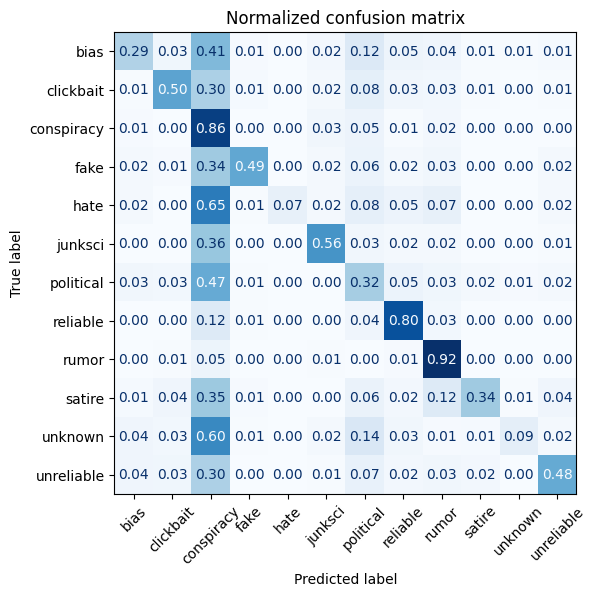

Accuracy: 0.47805555555555557
Accuracy excluding political: 0.527066450567261


In [8]:
from sklearn.linear_model import PassiveAggressiveClassifier
lr = PassiveAggressiveClassifier()
check_model(lr, X_tr, y_tr, X_val, y_val)

## SVM

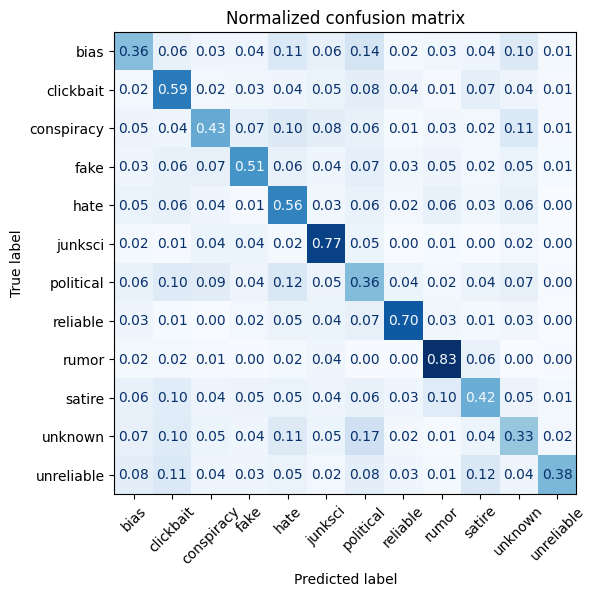

Accuracy: 0.5183333333333333
Accuracy excluding political: 0.5765824860610036


In [9]:
svm = SVC(max_iter=3000, random_state=42)
check_model(svm, X_tr, y_tr, X_val, y_val)

## Random forest

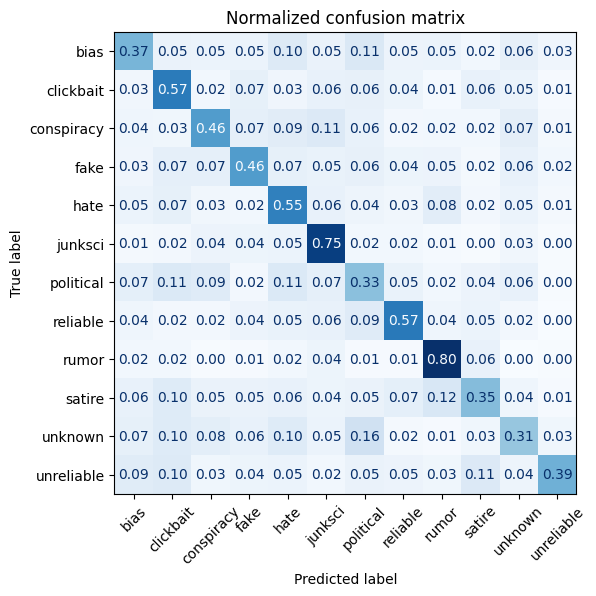

Accuracy: 0.4911111111111111
Accuracy excluding political: 0.540304305600518


In [10]:
rf = RandomForestClassifier(random_state=42)
check_model(rf, X_tr, y_tr, X_val, y_val)

## Naive Bayess

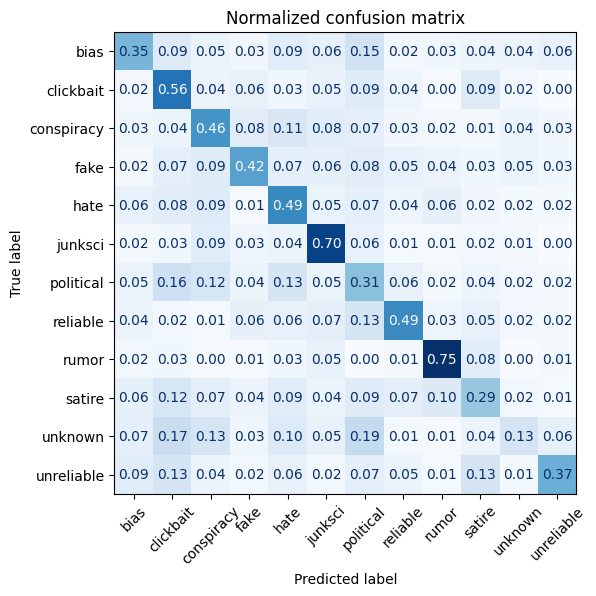

Accuracy: 0.4438888888888889
Accuracy excluding political: 0.5008319467554077


In [11]:
nb = BernoulliNB()
check_model(nb, X_tr, y_tr, X_val, y_val)

# DistilBERT

In [12]:
def train_bert(data_x, data_y, name="", plot=True):
    """Method that performs tokenization data preprocessing, initializing and model training. Method also returns the main statistics about predictions
    Args:
        data_x : training data
        data_y : training target
        name : output model file name
        plot : flag if confusion matrix should be drawn
    Returns:
        accuracy
        accuracy without political class
        confusion matrix
    """
    
    X_train2, X_valid2, y_train2, y_valid2 = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # custom dataset that works with our data
    class CustomDataset(Dataset):
        def __init__(self, X, y, tokenizer, max_length):
            self.X = X
            self.y = y
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            inputs = self.tokenizer(
                self.X[idx],
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )

            return {
                'input_ids': inputs['input_ids'].squeeze(),
                'attention_mask': inputs['attention_mask'].squeeze(),
                'labels': torch.tensor(self.y[idx])
            }

    train_dataset = CustomDataset(X_train2, y_train2, tokenizer, max_length=100)
    valid_dataset = CustomDataset(X_valid2, y_valid2, tokenizer, max_length=100)

    # model definition
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(np.unique(y)))

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        seed=123
    )

    # model training
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
    )
    
    if name == "":
        name = 'models/bert/main'
        
    trainer.train() # training the model
    trainer.save_model(name) # saving model to file
    
    # prediction for validation dataset
    preds_output = trainer.predict(valid_dataset)
    y_preds = np.argmax(preds_output.predictions, axis=1)

    # visualisation of results
    cm = plot_confusion_matrix(y_preds, y_valid2, main_df['type'].astype('category').cat.categories, plot = plot)
    acc = accuracy_score(y_preds, y_valid2)
    indexes = [True if y_preds[i]!=6 and y_valid2[i]!=6 else False for i in range(len(y_preds))]
    acc_pol = accuracy_score(y_preds[indexes], np.array(y_valid2)[indexes])
    if plot:
        print(f"Accuracy: {acc}")
        print(f"Accuracy excluding political: {acc_pol}")
    return acc, acc_pol, cm

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3600 [00:00<?, ?it/s]

{'loss': 1.9953, 'learning_rate': 5e-05, 'epoch': 0.42}
{'loss': 1.2813, 'learning_rate': 4.1935483870967746e-05, 'epoch': 0.83}
{'loss': 0.9756, 'learning_rate': 3.387096774193548e-05, 'epoch': 1.25}
{'loss': 0.8256, 'learning_rate': 2.5806451612903226e-05, 'epoch': 1.67}
{'loss': 0.7325, 'learning_rate': 1.774193548387097e-05, 'epoch': 2.08}
{'loss': 0.4351, 'learning_rate': 9.67741935483871e-06, 'epoch': 2.5}
{'loss': 0.418, 'learning_rate': 1.6129032258064516e-06, 'epoch': 2.92}
{'train_runtime': 9464.7476, 'train_samples_per_second': 3.043, 'train_steps_per_second': 0.38, 'train_loss': 0.9366947015126547, 'epoch': 3.0}


  0%|          | 0/300 [00:00<?, ?it/s]

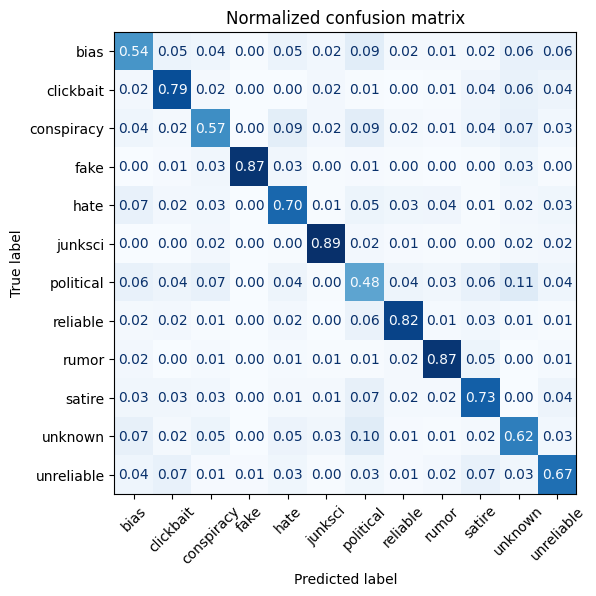

Accuracy: 0.7133333333333334
Accuracy excluding political: 0.7727272727272727


(0.7133333333333334,
 0.7727272727272727,
 array([[0.54228856, 0.05472637, 0.039801  , 0.00497512, 0.05472637,
         0.02487562, 0.09452736, 0.0199005 , 0.01492537, 0.0199005 ,
         0.06467662, 0.06467662],
        [0.02162162, 0.78918919, 0.01621622, 0.        , 0.        ,
         0.02162162, 0.00540541, 0.        , 0.00540541, 0.03783784,
         0.05945946, 0.04324324],
        [0.04166667, 0.01851852, 0.56944444, 0.        , 0.08796296,
         0.02314815, 0.09259259, 0.01851852, 0.00925926, 0.04166667,
         0.06944444, 0.02777778],
        [0.        , 0.00952381, 0.02857143, 0.87142857, 0.02857143,
         0.0047619 , 0.00952381, 0.0047619 , 0.        , 0.0047619 ,
         0.03333333, 0.0047619 ],
        [0.06878307, 0.02116402, 0.02645503, 0.        , 0.7037037 ,
         0.00529101, 0.04761905, 0.03174603, 0.03703704, 0.00529101,
         0.02116402, 0.03174603],
        [0.        , 0.        , 0.02252252, 0.        , 0.0045045 ,
         0.89189189, 0.022522

In [13]:
train_bert(list(X), list(y), name="", plot=True)

# Models based on clusters

In [35]:
labels = main_df['type'].astype('category').cat.categories

def check_model_clustering(model, clustering):
    """Combined method which trains model and visualizes results for each topic separately aand combines the results
    Args:
        model : sklearn machine learning object
        clustering : column name with clusters
    Returns:
        results : data frame with most important results
        weighted_accuracy : number weighted mean of accuracies
    """
    accuracies = []
    accuracies_pol = []
    diagonals = []
    size = []
    data = np.array(hidden)
    # Main loop
    for i in range(np.max(main_df[clustering])+1):
        X_tr, X_val, y_tr, y_val = train_test_split(data[main_df[clustering]==i], y[main_df[clustering]==i], test_size=0.3, random_state=42)
        lr = copy(model)
        acc, acc_pol, cm = check_model(lr, X_tr, y_tr, X_val, y_val, plot=False, name= "models/"+str(model.__class__).split(".")[-1][:-2]+"/"+clustering+"/"+str(i))
        accuracies.append(acc)
        accuracies_pol.append(acc_pol)
        diagonals.append(np.diag(cm))
        size.append(len(y_tr)+len(y_val))

    # Joining results
    results = pd.DataFrame(diagonals)
    results.columns = labels
    results["____________"] = ["" for _ in range(results.shape[0])]
    results["accuracy"] = accuracies
    results["accuracy without political"] = accuracies_pol
    results["size"] = size
    weighted_accuracy = np.sum(results["size"] * results["accuracy"])/np.sum(results["size"])
    
    # Display results
    print("_"*((100-len(str(model.__class__).split(".")[-1][:-2]))//2)+ " " +str(model.__class__).split(".")[-1][:-2]+" "+"_"*((100-len(str(model.__class__).split(".")[-1][:-2]))//2)) # Model name with some padding
    results = results.round(2)
    display(results)
    with open(f'LaTeX/results_{clustering}_{str(model.__class__).split(".")[-1][:-2]}.txt', 'w') as f:
        f.write(results.to_latex(header=True, index=False, float_format='%.2f'))
    
    print(f"Weighted accuracy: {weighted_accuracy}")
    return results, weighted_accuracy

In [36]:
clustering = "clustering_lda"
for model in [LogisticRegression(max_iter=3000, random_state=42), SVC(max_iter=3000, random_state=42), RandomForestClassifier(random_state=42), BernoulliNB()]:
    check_model_clustering(model, clustering)
print("done")

_________________________________________ LogisticRegression _________________________________________


,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable,____________,accuracy,accuracy without political,size
0,0.44,0.61,0.41,0.49,0.61,0.61,0.38,0.74,0.77,0.51,0.41,0.50,,0.54,0.58,2995
1,0.29,0.60,0.46,0.42,0.36,0.74,0.28,0.68,0.78,0.49,0.40,0.46,,0.50,0.55,2862
2,0.47,0.58,0.45,0.53,0.52,0.63,0.33,0.68,0.79,0.56,0.42,0.51,,0.53,0.59,2981
3,0.29,0.62,0.38,0.57,0.68,0.75,0.28,0.76,0.81,0.38,0.27,0.46,,0.52,0.59,3162


Weighted accuracy: 0.5230419368179826
________________________________________________ SVC ________________________________________________


,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable,____________,accuracy,accuracy without political,size
0,0.44,0.57,0.45,0.41,0.64,0.63,0.32,0.57,0.82,0.33,0.29,0.36,,0.49,0.54,2995
1,0.30,0.53,0.49,0.33,0.43,0.69,0.43,0.58,0.79,0.33,0.24,0.41,,0.46,0.52,2862
2,0.39,0.58,0.50,0.39,0.59,0.63,0.34,0.63,0.75,0.55,0.21,0.31,,0.48,0.55,2981
3,0.25,0.48,0.46,0.35,0.72,0.73,0.42,0.61,0.79,0.34,0.06,0.37,,0.48,0.54,3162


Weighted accuracy: 0.4764016859413568
_______________________________________ RandomForestClassifier _______________________________________


,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable,____________,accuracy,accuracy without political,size
0,0.41,0.54,0.48,0.35,0.57,0.62,0.27,0.49,0.81,0.29,0.26,0.40,,0.46,0.50,2995
1,0.30,0.60,0.49,0.31,0.40,0.74,0.28,0.42,0.77,0.33,0.27,0.44,,0.45,0.50,2862
2,0.45,0.57,0.47,0.32,0.50,0.59,0.19,0.54,0.79,0.42,0.29,0.39,,0.45,0.51,2981
3,0.26,0.56,0.36,0.36,0.68,0.75,0.30,0.61,0.80,0.32,0.12,0.42,,0.47,0.53,3162


Weighted accuracy: 0.4569691493903986
____________________________________________ BernoulliNB ____________________________________________


,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable,____________,accuracy,accuracy without political,size
0,0.35,0.66,0.51,0.39,0.51,0.63,0.32,0.54,0.78,0.31,0.15,0.37,,0.46,0.51,2995
1,0.29,0.65,0.53,0.36,0.51,0.66,0.28,0.44,0.72,0.29,0.14,0.41,,0.44,0.49,2862
2,0.42,0.57,0.51,0.45,0.45,0.58,0.27,0.51,0.79,0.41,0.09,0.33,,0.44,0.50,2981
3,0.25,0.54,0.44,0.38,0.60,0.73,0.35,0.42,0.71,0.31,0.08,0.41,,0.44,0.50,3162


Weighted accuracy: 0.44586357163328605
done


In [37]:
clustering = "clustering_gss"
for model in [LogisticRegression(max_iter=3000, random_state=42), SVC(max_iter=3000, random_state=42), RandomForestClassifier(random_state=42), BernoulliNB()]:
    check_model_clustering(model, clustering)
print("done")

_________________________________________ LogisticRegression _________________________________________


,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable,____________,accuracy,accuracy without political,size
0,0.69,0.33,0.36,0.50,0.60,0.00,0.32,0.45,0.73,0.45,0.32,0.41,,0.52,0.54,1393
1,0.21,0.25,0.69,0.56,0.52,0.55,0.33,0.61,0.58,0.41,0.25,0.25,,0.49,0.54,1296
2,0.80,0.41,0.56,0.88,0.25,0.33,0.10,0.79,0.96,0.57,0.00,0.63,,0.70,0.75,951
3,0.10,0.53,0.32,0.62,0.30,0.73,0.28,0.72,0.83,0.49,0.14,0.15,,0.54,0.58,1028
4,0.14,0.74,0.26,0.28,0.43,0.20,0.61,0.42,0.00,0.57,0.44,0.10,,0.46,0.52,1766
5,0.15,0.70,0.68,0.40,0.50,0.45,0.05,0.80,0.84,0.61,0.23,0.41,,0.58,0.63,1057
6,0.40,0.53,0.24,0.35,0.72,0.86,0.27,0.72,0.74,0.30,0.38,0.76,,0.55,0.61,4509


Weighted accuracy: 0.5403502440145534
________________________________________________ SVC ________________________________________________


,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable,____________,accuracy,accuracy without political,size
0,0.85,0.00,0.33,0.05,0.74,0.00,0.00,0.00,0.66,0.29,0.00,0.00,,0.40,0.43,1393
1,0.00,0.00,0.79,0.50,0.40,0.50,0.58,0.43,0.55,0.21,0.00,0.00,,0.42,0.47,1296
2,0.76,0.00,0.00,0.92,0.00,0.00,0.00,0.62,0.91,0.64,0.00,0.00,,0.55,0.57,951
3,0.00,0.42,0.14,0.46,0.00,0.70,0.00,0.59,0.89,0.47,0.00,0.00,,0.45,0.49,1028
4,0.00,0.77,0.09,0.00,0.29,0.00,0.80,0.00,0.00,0.16,0.19,0.00,,0.36,0.51,1766
5,0.10,0.15,0.71,0.40,0.43,0.09,0.00,0.80,0.73,0.88,0.00,0.00,,0.50,0.54,1057
6,0.27,0.46,0.12,0.26,0.77,0.86,0.22,0.65,0.64,0.04,0.50,0.74,,0.51,0.57,4509


Weighted accuracy: 0.46292843178771365
_______________________________________ RandomForestClassifier _______________________________________


,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable,____________,accuracy,accuracy without political,size
0,0.86,0.00,0.39,0.18,0.59,0.00,0.14,0.10,0.66,0.31,0.09,0.24,,0.44,0.46,1393
1,0.05,0.25,0.70,0.54,0.40,0.57,0.21,0.43,0.61,0.06,0.06,0.00,,0.41,0.46,1296
2,0.76,0.09,0.06,0.92,0.00,0.00,0.00,0.71,0.91,0.74,0.00,0.07,,0.59,0.62,951
3,0.00,0.37,0.55,0.46,0.10,0.63,0.08,0.66,0.90,0.23,0.07,0.00,,0.46,0.50,1028
4,0.06,0.72,0.18,0.03,0.29,0.00,0.70,0.08,0.00,0.32,0.27,0.00,,0.37,0.48,1766
5,0.10,0.58,0.68,0.40,0.29,0.27,0.00,0.78,0.82,0.73,0.00,0.12,,0.53,0.57,1057
6,0.33,0.53,0.15,0.17,0.75,0.89,0.26,0.56,0.55,0.00,0.34,0.74,,0.49,0.54,4509


Weighted accuracy: 0.46791184416995263
____________________________________________ BernoulliNB ____________________________________________


,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable,____________,accuracy,accuracy without political,size
0,0.73,0.11,0.44,0.50,0.36,0.00,0.23,0.14,0.61,0.40,0.15,0.21,,0.42,0.44,1393
1,0.16,0.25,0.64,0.48,0.40,0.45,0.21,0.43,0.65,0.24,0.12,0.25,,0.41,0.46,1296
2,0.76,0.64,0.56,0.68,0.50,0.00,0.00,0.62,0.82,0.21,0.00,0.41,,0.55,0.61,951
3,0.20,0.58,0.64,0.46,0.30,0.73,0.20,0.34,0.83,0.26,0.14,0.08,,0.47,0.53,1028
4,0.14,0.62,0.38,0.19,0.39,0.00,0.51,0.38,0.50,0.41,0.16,0.10,,0.38,0.44,1766
5,0.10,0.61,0.74,0.27,0.50,0.36,0.05,0.66,0.76,0.32,0.15,0.35,,0.47,0.52,1057
6,0.21,0.59,0.15,0.29,0.62,0.72,0.27,0.53,0.66,0.30,0.13,0.74,,0.45,0.51,4509


Weighted accuracy: 0.4421041049190929
done


In [38]:
for clustering in ["clustering_gss", "clustering_lda"]:
    
    accuracies = []
    accuracies_pol = []
    diagonals = []
    size = []
    
    # Model training and collecting of the results
    for i in range(np.max(main_df[clustering])+1):
        acc, acc_pol, cm = train_bert(list(X[main_df[clustering]==i]), list(y[main_df[clustering]==i]), name=f"models/bert/{clustering}/{i}", plot=False)
        accuracies.append(acc)
        accuracies_pol.append(acc_pol)
        diagonals.append(np.diag(cm))
        size.append(len(list(y[main_df[clustering]==i])))
        
    # Joining results
    results = pd.DataFrame(diagonals)
    results.columns = labels
    results["____________"] = ["" for _ in range(results.shape[0])]
    results["accuracy"] = accuracies
    results["accuracy without political"] = accuracies_pol
    results["size"] = size
    weighted_accuracy = np.sum(results["size"] * results["accuracy"])/np.sum(results["size"])
    results = results.round(2)
    # Displaying results
    print("_"*((100-len(clustering))//2)+ " " +clustering+" "+"_"*((100-len(clustering))//2)) # Model name with some padding
    display(results)
    with open(f'LaTeX/results_{clustering}_DistilBERT.txt', 'w') as f:
        f.write(results.to_latex(header=True, index=False, float_format='%.2f'))
    print(f"Weighted accuracy: {weighted_accuracy}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/420 [00:00<?, ?it/s]

{'train_runtime': 1087.7267, 'train_samples_per_second': 3.072, 'train_steps_per_second': 0.386, 'train_loss': 1.9713171096075148, 'epoch': 3.0}


  0%|          | 0/35 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/390 [00:00<?, ?it/s]

{'train_runtime': 999.6924, 'train_samples_per_second': 3.109, 'train_steps_per_second': 0.39, 'train_loss': 2.016343962840545, 'epoch': 3.0}


  0%|          | 0/33 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/285 [00:00<?, ?it/s]

{'train_runtime': 736.9549, 'train_samples_per_second': 3.094, 'train_steps_per_second': 0.387, 'train_loss': 1.7297953287760417, 'epoch': 3.0}


  0%|          | 0/24 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/309 [00:00<?, ?it/s]

{'train_runtime': 792.52, 'train_samples_per_second': 3.112, 'train_steps_per_second': 0.39, 'train_loss': 2.095799122041869, 'epoch': 3.0}


  0%|          | 0/26 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/531 [00:00<?, ?it/s]

{'loss': 1.8853, 'learning_rate': 5e-05, 'epoch': 2.82}
{'train_runtime': 1424.4585, 'train_samples_per_second': 2.974, 'train_steps_per_second': 0.373, 'train_loss': 1.8501325991643127, 'epoch': 3.0}


  0%|          | 0/45 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/318 [00:00<?, ?it/s]

{'train_runtime': 846.0115, 'train_samples_per_second': 2.996, 'train_steps_per_second': 0.376, 'train_loss': 2.0589507480837264, 'epoch': 3.0}


  0%|          | 0/27 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1353 [00:00<?, ?it/s]

{'loss': 1.867, 'learning_rate': 5e-05, 'epoch': 1.11}
{'loss': 1.02, 'learning_rate': 2.0691676436107857e-05, 'epoch': 2.22}
{'train_runtime': 3799.4186, 'train_samples_per_second': 2.848, 'train_steps_per_second': 0.356, 'train_loss': 1.222992360635942, 'epoch': 3.0}


  0%|          | 0/113 [00:00<?, ?it/s]

___________________________________________ clustering_gss ___________________________________________


,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable,____________,accuracy,accuracy without political,size
0,0.62,0.33,0.26,0.88,0.47,0.00,0.00,0.41,0.94,0.67,0.46,0.29,,0.52,0.56,1393
1,0.00,0.42,0.55,0.97,0.67,0.97,0.60,0.62,0.75,0.27,0.11,0.00,,0.57,0.64,1296
2,0.76,0.14,0.00,0.89,0.00,0.00,0.00,0.78,0.95,0.69,0.00,0.00,,0.58,0.59,951
3,0.00,0.86,0.27,0.76,0.17,0.89,0.06,0.61,0.70,0.73,0.00,0.00,,0.55,0.60,1028
4,0.22,0.76,0.10,0.81,0.50,1.00,0.81,0.05,0.00,0.52,0.55,0.17,,0.53,0.67,1766
5,0.15,0.77,0.65,0.67,0.50,0.20,0.00,0.90,0.77,0.69,0.00,0.00,,0.57,0.61,1057
6,0.45,0.68,0.47,0.94,0.76,0.85,0.38,0.73,0.64,0.58,0.60,0.79,,0.67,0.75,4509


Weighted accuracy: 0.5961456649698882


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/900 [00:00<?, ?it/s]

{'loss': 1.9742, 'learning_rate': 5e-05, 'epoch': 1.67}
{'train_runtime': 2477.6822, 'train_samples_per_second': 2.901, 'train_steps_per_second': 0.363, 'train_loss': 1.5213097466362848, 'epoch': 3.0}


  0%|          | 0/75 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/861 [00:00<?, ?it/s]

{'loss': 1.9158, 'learning_rate': 5e-05, 'epoch': 1.74}
{'train_runtime': 2359.7534, 'train_samples_per_second': 2.91, 'train_steps_per_second': 0.365, 'train_loss': 1.4653799519998547, 'epoch': 3.0}


  0%|          | 0/72 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/894 [00:00<?, ?it/s]

{'loss': 1.9672, 'learning_rate': 5e-05, 'epoch': 1.68}
{'train_runtime': 2448.7528, 'train_samples_per_second': 2.921, 'train_steps_per_second': 0.365, 'train_loss': 1.5068820552271218, 'epoch': 3.0}


  0%|          | 0/75 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/951 [00:00<?, ?it/s]

{'loss': 2.0181, 'learning_rate': 5e-05, 'epoch': 1.58}
{'train_runtime': 2608.5424, 'train_samples_per_second': 2.909, 'train_steps_per_second': 0.365, 'train_loss': 1.5079017101652865, 'epoch': 3.0}


  0%|          | 0/80 [00:00<?, ?it/s]

___________________________________________ clustering_lda ___________________________________________


,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable,____________,accuracy,accuracy without political,size
0,0.53,0.70,0.52,0.92,0.71,0.78,0.52,0.60,0.87,0.54,0.49,0.63,,0.65,0.70,2995
1,0.37,0.74,0.61,0.89,0.55,0.80,0.17,0.72,0.82,0.71,0.57,0.47,,0.63,0.69,2862
2,0.49,0.64,0.56,0.82,0.57,0.80,0.34,0.65,0.76,0.70,0.43,0.46,,0.59,0.67,2981
3,0.30,0.79,0.33,0.88,0.74,0.91,0.54,0.78,0.78,0.37,0.48,0.42,,0.61,0.71,3162


Weighted accuracy: 0.618660816457913
